## Walk-Forward Forecast with Univariate Stateful LSTM
In this notebook a walkforward forecasting approach is taken with the univariate LSTM architecture [demonstrated here](https://github.com/anasashb/brent_price_forecasting/tree/main/univariate_lstm).

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import stataments, including unused imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras.optimizers import Adam
import tensorflow as tf
import pickle

# Seeds
tf.random.set_seed(66)
np.random.seed(66)

# Plot configurations
plt.rcParams['figure.figsize'] = (12, 6.75)
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 24

# Error metrics
def rmse(true, predicted):
    return np.sqrt(np.mean(np.square(predicted - true)))
def mape(true, predicted):
    true, predicted = np.array(true), np.array(predicted)
    return np.mean(np.abs((true - predicted) / true)) * 100




2023-07-25 13:23:37.711012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


### **Data:**

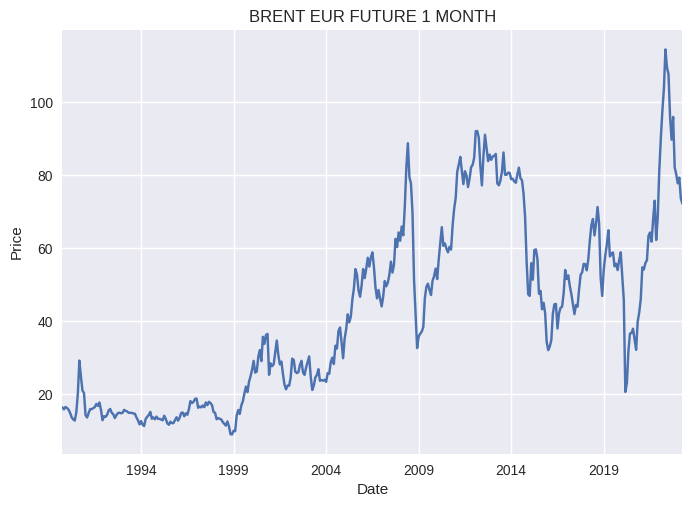

In [2]:
brentpath = '/home/RDC/anasashb/Dokumente/ECXLOC/BRENTDATA.csv'

# Import data set
BRENT = pd.read_csv(brentpath,
                   index_col = 'Date',
                   parse_dates = True)
BRENT = pd.Series(BRENT['EUR Future 1 Month'])

# Plot
BRENT.plot()
plt.title('BRENT EUR FUTURE 1 MONTH')
plt.ylabel('Price')
plt.show()

### Data Preprocessing
Pre-processing as well as model architecture is identical with the univariate LSTM [demonstrated here](https://github.com/anasashb/brent_price_forecasting/tree/main/univariate_lstm).

Since in this case we'll be using the lag order of 1 and batch size of 1, input dimensions will not be a problem in terms of divisibility with the batch size. 

The set lengths are generated same as in the tuning notebook. 

In [3]:
# Store Date
dates = BRENT.index
# Get values for the series
series = BRENT.values.astype('float32').reshape(-1,1)


In [4]:
# Specify batch_size
batch_size = 10
# Specify lag order
timesteps = 1

In [5]:
# Define test, validation and train sizes
test_size = 81
val_size = 51
train_size = 271
print(test_size+val_size+train_size)

403


In [6]:
# Train-val-test split
train = series[:train_size]
val = series[train_size:train_size+val_size]
test = series[train_size+val_size:]

# Important to obtain the retrain set at this stage
# because we will lose observations if we concatenate 
# the sets after tensors have been generated
retrain = np.concatenate((train, val), axis = 0)

# Check
len(train)+len(val)==len(retrain)



True

In [7]:
# Scale and Generate Tensors

# Scaling: Use (-1,1) for better input to hyperbolic tangent
# Fit on train set
scaler = MinMaxScaler(feature_range = (-1, 1)).fit(train)

# Scale everything per train data parameters
train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
retrain = scaler.transform(retrain)

# Reshape as LSTM inputs:
def generate_tensors(series, timesteps):
    
    dataX, dataY = [], []
    
    for i in range(0, len(series) - timesteps):
        x = np.reshape(series[i:i + timesteps], (-1,1))
        dataX.append(x)
        y = series[i +timesteps]
        dataY.append(y)
    
    return np.array(dataX), np.array(dataY)
                 

X_train, y_train = generate_tensors(train, timesteps)
X_val, y_val = generate_tensors(val, timesteps)
X_test, y_test = generate_tensors(test, timesteps)
X_retrain, y_retrain = generate_tensors(retrain, timesteps)

In [8]:
# Check shapes
tensors = [X_train, y_train, X_val, y_val, X_test, y_test, X_retrain, y_retrain]

for i, tensor in enumerate(tensors):
    print(f'{tensor.shape}')

# Remove unneeded variable
del tensors

(270, 1, 1)
(270, 1)
(50, 1, 1)
(50, 1)
(80, 1, 1)
(80, 1)
(321, 1, 1)
(321, 1)


In [14]:
# Path for results
path = '/home/RDC/anasashb/Dokumente/ECXLOC/WFTUNEDL1B10 /Data/'

### **Model Architecture, Training, Predicting**

In [28]:
model = Sequential()
model.add(LSTM(45,
                         activation = 'tanh',
                         recurrent_activation = 'sigmoid',
                         kernel_regularizer = regularizers.L2(1e-3),
                         recurrent_regularizer = regularizers.L2(1e-3),
                         bias_regularizer = regularizers.L2(1e-3),
                         recurrent_dropout=0,
                         unroll=False,
                         use_bias = True,
                         stateful = True,
                         return_sequences = False,
                         batch_input_shape = (batch_size, timesteps, 1)
                         ))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mape'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 45)                   8460      
_________________________________________________________________
dropout_2 (Dropout)          (1, 45)                   0         
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    46        
Total params: 8,506
Trainable params: 8,506
Non-trainable params: 0
_________________________________________________________________


For walk-forward validation, first we define a training function that we'll then put in a loop

In [30]:
# Stateful training
def train_model(model, X_train, y_train, epochs=100, patience=10, min_delta=0.001):
    # Set up variables for early stopping
    best_train_loss = np.inf
    wait = 0

    # Empty containers to store training losses.
    train_losses = []

    # Training loop for given number of epochs
    for i in range(epochs):
        history = model.fit(X_train,
                            y_train,
                            epochs = 1,
                            batch_size = batch_size,
                            verbose = 0,
                            shuffle = False)
        # Reset cell states after one epoch
        model.reset_states()
        
        # Calculate training losses
        train_loss = history.history['loss'][0]
        
        # Append losses
        train_losses.append(train_loss)
        
        # Check for early stopping
        if np.abs(train_loss - best_train_loss) > min_delta:
            best_train_loss = train_loss
            wait = 0
            
        else:
            wait += 1
            if wait >= patience:
                print(f'early stopping on epoch: {i+1}')
                break
        
        print(f'Epoch {i + 1} - Training Loss: {train_loss}') 
    
    return model, train_losses

In [31]:
# Copy the sets for WF forecasting
WFX_train = X_retrain.copy()
WFy_train = y_retrain.copy()
WFX_test = X_test.copy()
WFy_test = y_test.copy()

Below the walk forward forecasting loop is demonstrated

In [32]:
# Compile model
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mape'])

# Empty list for predictions
y_pred = []

# Iterate until we go through entire test set
for i in range(len(WFX_test)):
    # Train
    model, _ = train_model(model = model, X_train = WFX_train, y_train = WFy_train)
    # Predict step-ahead
    pred = model.predict(WFX_test[i:i+1], verbose=0, batch_size=batch_size)
    # Append prediction to list
    y_pred.append(pred[0][0])
    # Add input from test set to train
    WFX_train = np.concatenate((WFX_train, WFX_test[i:i+1]), axis=0)
    WFy_train = np.concatenate((WFy_train, WFy_test[i:i+1]), axis=0)

# Unscale predictions
y_pred_unsc = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unsc = scaler.inverse_transform(y_test)

# Compute metrics
rmse_value = rmse(y_test_unsc, y_pred_unsc)
mape_value = mape(y_test_unsc, y_pred_unsc)

# Print metrics
print(f'\nThe RMSE is: {rmse_value}')
print(f'\nThe MAPE is: {mape_value}')

Epoch 1 - Training Loss: 0.10536497086286545
Epoch 2 - Training Loss: 0.05646384879946709
Epoch 3 - Training Loss: 0.03604467213153839
Epoch 4 - Training Loss: 0.026525242254137993
Epoch 5 - Training Loss: 0.02245585061609745
Epoch 6 - Training Loss: 0.018749283626675606
Epoch 7 - Training Loss: 0.01726406253874302
Epoch 8 - Training Loss: 0.016442501917481422
Epoch 9 - Training Loss: 0.016031956300139427
Epoch 10 - Training Loss: 0.016367755830287933
Epoch 11 - Training Loss: 0.016054511070251465
Epoch 12 - Training Loss: 0.015789028257131577
Epoch 13 - Training Loss: 0.014512808993458748
Epoch 14 - Training Loss: 0.015823954716324806
Epoch 15 - Training Loss: 0.014668414369225502
Epoch 16 - Training Loss: 0.015778256580233574
Epoch 17 - Training Loss: 0.015295940451323986
Epoch 18 - Training Loss: 0.01628367230296135
Epoch 19 - Training Loss: 0.015445691533386707
Epoch 20 - Training Loss: 0.015685370191931725
Epoch 21 - Training Loss: 0.01567172072827816
Epoch 22 - Training Loss: 0.0

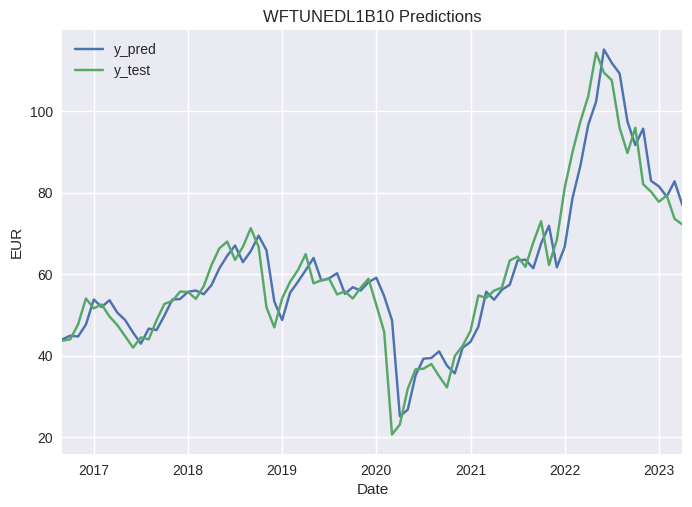

In [34]:
# Plot
test_dates = dates[-len(y_test):]
df = pd.DataFrame({'y_pred': np.array(y_pred_unsc).flatten(), 'y_test': y_test_unsc.flatten()})
df.set_index(test_dates, inplace = True)
df.plot()
plt.title('WFTUNEDL1B10 Predictions')
plt.savefig(path+'WFTUNEDL1B10_Forecast.png', transparent = True, dpi = 300)
plt.ylabel('EUR') 
plt.show()
plt.close()

In [35]:
with open(path+'WFTUNEDL1B10_Results.pkl', 'wb') as f: # Rename
    pickle.dump(df, f)